In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob

"""Change to the data folder"""
train_path = ".\\new_train\\new2\\"
val_path = ".\\new_train\\ts\\"
predict_path = ".\\new_val_in\\new_val_in\\"
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data



# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=train_path)
val_dataset = ArgoverseDataset(data_path=val_path)
predict_dataset = ArgoverseDataset(data_path=predict_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 1024

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [scene['p_in'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    out = [scene['p_out'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    inp = torch.tensor(inp, device=dev).squeeze()
    out = torch.tensor(out, device=dev).squeeze()

    base = inp[:,0,:].clone().reshape(-1,1,2)
    #l = (inp[:,-1,:]-inp[:,0,:]).clone().reshape(-1,1,2)
    inp = ((inp - base)).permute(1,0,2)
    out = ((out - base)).permute(1,0,2)

    #print(inp.shape)
    #print(inp)

    return [inp, out]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [4]:
predict_batch_sz = 4

def my_predict_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    IDs = [scene['scene_idx'] for scene in batch]

    inp = [scene['p_in'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    inp = torch.tensor(inp).squeeze()
    
    base = inp[:,0,:].clone().reshape(-1,1,2).cpu()
    inp = (inp - base).permute(1,0,2).to(dev)

    return [inp, base, IDs]

predict_loader = DataLoader(predict_dataset,batch_size=predict_batch_sz, shuffle = False, collate_fn=my_predict_collate, num_workers=0)

In [5]:
print(len(train_loader))
print(len(val_loader))
print(len(predict_loader))
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape)
    print(inp.permute(1,0,2)[1])
    print(out.shape)
    print(out.permute(1,0,2)[1])
    #print(out)
    print()
    break

5
5
800
torch.Size([19, 1024, 2])
tensor([[ 0.0000,  0.0000],
        [-0.1163,  0.0547],
        [-0.0312,  0.1594],
        [-0.1488,  0.0054],
        [-0.0899, -0.0078],
        [-0.1457,  0.0811],
        [-0.1752,  0.0159],
        [-0.2319,  0.0227],
        [-0.3044,  0.0400],
        [-0.1472,  0.0911],
        [-0.4168,  0.0557],
        [-0.5121, -0.0022],
        [-0.3758,  0.1748],
        [-0.4273,  0.1050],
        [-0.6562,  0.0510],
        [-0.7619, -0.0046],
        [-0.7832, -0.0288],
        [-0.8316, -0.0063],
        [-0.9773, -0.0027]], device='cuda:0', dtype=torch.float64)
torch.Size([30, 1024, 2])
tensor([[-9.9236e-01, -2.2217e-02],
        [-1.2175e+00,  6.3477e-03],
        [-1.3043e+00, -1.8066e-02],
        [-1.3497e+00, -1.0742e-02],
        [-1.5419e+00, -7.3975e-02],
        [-1.7247e+00, -1.1719e-02],
        [-1.7463e+00, -2.3926e-02],
        [-1.9243e+00,  9.7656e-03],
        [-2.0974e+00,  1.4160e-02],
        [-2.3902e+00, -6.0303e-02],
        [

In [6]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: input batch data, size: [sequence len, batch size, feature size]
        for the argoverse trajectory data, size(x) is [19, batch size, 4]
        """
        # embedded: [sequence len, batch size, embedding size]
        embedded = self.dropout(F.relu(self.linear(x)))
        # you can checkout https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM
        # for details of the return tensor
        # briefly speaking, output coontains the output of last layer for each time step
        # hidden and cell contains the last time step hidden and cell state of each layer
        # we only use hidden and cell as context to feed into decoder
        output, (hidden, cell) = self.rnn(embedded)
        # hidden = [n layers * n directions, batch size, hidden size]
        # cell = [n layers * n directions, batch size, hidden size]
        # the n direction is 1 since we are not using bidirectional RNNs
        return hidden, cell
    

In [7]:
class Decoder(nn.Module):
    def __init__(self,
                 output_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        """
        x : input batch data, size(x): [batch size, feature size]
        notice x only has two dimensions since the input is batchs
        of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        # after this, size(x) will be [1, batch size, feature size]
        x = x.unsqueeze(0)

        # embedded = [1, batch size, embedding size]
        embedded = self.dropout(F.relu(self.embedding(x)))

        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hidden size]
        #hidden = [n layers, batch size, hidden size]
        #cell = [n layers, batch size, hidden size]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # prediction = [batch size, output size]
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell
    

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio = 0.5):
        """
        x = [observed sequence len, batch size, feature size]
        y = [target sequence len, batch size, feature size]
        for our argoverse motion forecasting dataset
        observed sequence len is 19, target sequence len is 30
        feature size for now is just 4 (x and y)

        teacher_forcing_ratio is probability of using teacher forcing
        e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(x)

        # first input to decoder is last coordinates of x
        decoder_input = x[-1, :, :]
        
        for i in range(target_len):
            # run decode for one time step
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # place predictions in a tensor holding predictions for each time step
            outputs[i] = output

            # decide if we are going to use teacher forcing or not
            teacher_forcing = random.random() < teacher_forcing_ratio

            # output is the same shape as input, [batch_size, feature size]
            # so we can use output directly as input or use true lable depending on
            # teacher_forcing is true or not
            decoder_input = y[i] if teacher_forcing else output

        return outputs

In [9]:
INPUT_DIM = 2
OUTPUT_DIM = 2
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, dev).to(dev)

#optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,949,826 trainable parameters


In [11]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        if i % 10 == 0:
            print(i)
        # put data into GPU
        x = x.to(dev)
        y = y.to(dev)
        #print(x.shape)
        #print(y.shape)
        # zero all param gradients
        optimizer.zero_grad()
        
        # run seq2seq to get predictions
        y_pred = model(x.float(), y.float(), teacher_forcing_ratio = 0)
        
        # get loss and compute model trainable params gradients though backpropagation
        loss = criterion(y_pred, y.float())
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # add batch loss, since loss is single item tensor
        # we can get its value by loss.item()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [12]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(dev)
            y = y.to(dev)
            
            # turn off teacher forcing
            y_pred = model(x.float(), y.float(), teacher_forcing_ratio = 0)
            
            loss = criterion(y_pred, y.float())
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [13]:
def testtt(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.float().to(dev)
            y = y.float().to(dev)
            
            # turn off teacher forcing
            y_pred = model(x.float(), y, teacher_forcing_ratio = 0)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
            if i == 2:
                print(x.transpose(0, 1)[0])
                print(torch.cat((y.transpose(0, 1)[0], y_pred.transpose(0, 1)[0]), 1))
                #np.savetxt('exp2.csv',np.array(x.transpose(0, 1)[0].cpu()), delimiter=',')
                #np.savetxt('pre2.csv',np.array(torch.cat((y.transpose(0, 1)[0], y_pred.transpose(0, 1)[0]), 1).cpu()), delimiter=',')
                break
                
    return epoch_loss / len(dataloader)

In [14]:
import pandas as pd

def writefinal(model, dataloader):
    model.eval()
    epoch_loss = 0
    f = open('output.csv', 'a', newline = '\n')
    header = np.array(['ID'] + ['v' + str(i) for i in range(1,61)]).reshape(1,-1)
    np.savetxt(f, header,fmt='%s', delimiter=',')

    with torch.no_grad():
        for i, (x, base, IDs) in enumerate(dataloader):
            x = x.float().to(dev)
            y = torch.zeros(30,x.shape[1],2).float().to(dev)
            # turn off teacher forcing
            y_pred = model(x, y, teacher_forcing_ratio = 0)
            #print(y_pred)
            #loss = criterion(y_pred, y)
            #epoch_loss += loss.item()
            y_pred = np.array(y_pred.squeeze().permute(1,0,2).cpu() + base)
            
            y_pred = np.hstack((np.array(IDs).reshape(-1,1), y_pred.reshape(-1,60)))
            y_pred = pd.DataFrame(y_pred)
            y_pred[0] = y_pred[0].astype(int)
            y_pred.to_csv(f, header=False, index = False)
            if i % 200 == 0:
                print(i)
            
    f.close()
    #return epoch_loss / len(dataloader)

### Visualize the batch of sequences

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
best_val_loss = float('inf')

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [18]:
import os
import time
N_EPOCHES = 50


# load previous best model params if exists
model_dir = "saved_models/Seq2Seq"
#saved_model_path = model_dir + "/best_seq2seq" + time.ctime().replace(':', '_') + ".pt"
saved_model_path = model_dir + "/cc_best_seq2seq.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")

train_losses = []
val_losses = []
for epoch in range(N_EPOCHES):
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    mins, secs = epoch_time(start_time, end_time)
    
    print(F'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    """
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
        print('saved')
    """
"""
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq.pt"
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), saved_model_path)
"""

0
Epoch: 01 | Time: 0m 8s
	Train Loss: 493.999
	 Val. Loss: 395.672
0
Epoch: 02 | Time: 0m 7s
	Train Loss: 350.311
	 Val. Loss: 284.945
0
Epoch: 03 | Time: 0m 7s
	Train Loss: 287.887
	 Val. Loss: 267.426
0
Epoch: 04 | Time: 0m 6s
	Train Loss: 274.676
	 Val. Loss: 261.809
0
Epoch: 05 | Time: 0m 7s
	Train Loss: 259.900
	 Val. Loss: 237.195
0
Epoch: 06 | Time: 0m 9s
	Train Loss: 233.895
	 Val. Loss: 205.711
0
Epoch: 07 | Time: 0m 9s
	Train Loss: 213.396
	 Val. Loss: 197.001
0
Epoch: 08 | Time: 0m 9s
	Train Loss: 200.074
	 Val. Loss: 189.600
0
Epoch: 09 | Time: 0m 9s
	Train Loss: 196.940
	 Val. Loss: 216.500
0
Epoch: 10 | Time: 0m 9s
	Train Loss: 197.140
	 Val. Loss: 183.548
0
Epoch: 11 | Time: 0m 9s
	Train Loss: 181.677
	 Val. Loss: 171.606
0
Epoch: 12 | Time: 0m 9s
	Train Loss: 173.930
	 Val. Loss: 164.039
0
Epoch: 13 | Time: 0m 9s
	Train Loss: 167.939
	 Val. Loss: 159.945
0
Epoch: 14 | Time: 0m 8s
	Train Loss: 164.027
	 Val. Loss: 155.432
0
Epoch: 15 | Time: 0m 8s
	Train Loss: 160.444
	

'\nmodel_dir = "saved_models/Seq2Seq"\nsaved_model_path = model_dir + "/best_seq2seq.pt"\nos.makedirs(model_dir, exist_ok=True)\ntorch.save(model.state_dict(), saved_model_path)\n'

In [1]:
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/bb_best_seq2seq.pt"
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), saved_model_path)

NameError: name 'torch' is not defined

In [60]:
import numpy as np

np.savetxt("aaa.csv", np.array(train_losses), delimiter=",")

np.savetxt("bbb.csv", np.array(val_losses), delimiter=",")

In [ ]:
import os
import time
N_EPOCHES = 50
best_val_loss = float('inf')

"""
# load previous best model params if exists
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq" + time.ctime().replace(':', '_') + ".pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
"""
for epoch in range(1):
    start_time = time.time()
    
    #train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    mins, secs = epoch_time(start_time, end_time)
    
    print(F'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    #print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')

In [27]:

model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/a1_best_seq2seq.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")

writefinal(model, predict_loader)

successfully load previous best model parameters
0
200
400
600


In [23]:
"""
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seqSun May 16 16_42_43 2021.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
"""
val_loss = testtt(model, val_loader, criterion)

tensor([[  0.0000,   0.0000],
        [ -0.8452,  -0.2532],
        [ -1.6289,  -0.4395],
        [ -2.4819,  -0.5762],
        [ -2.8320,  -0.9504],
        [ -3.5674,  -1.1641],
        [ -4.3359,  -1.3665],
        [ -3.9956,  -1.9509],
        [ -4.7715,  -1.9939],
        [ -6.7334,  -1.7415],
        [ -7.4165,  -1.9678],
        [ -8.0664,  -1.8372],
        [ -8.7095,  -2.0596],
        [ -9.4678,  -2.1926],
        [-10.1562,  -2.3499],
        [-10.9438,  -2.4902],
        [-11.5698,  -2.7051],
        [-12.1172,  -2.8696],
        [-12.3330,  -2.9263]], device='cuda:0')
tensor([[-13.0854,  -3.1287, -13.3878,  -2.8679],
        [-13.0620,  -3.0432, -14.0386,  -2.5698],
        [-13.3271,  -3.1372, -14.9956,  -2.7090],
        [-13.0522,  -3.1472, -15.4350,  -2.7783],
        [-13.0679,  -3.1716, -15.8773,  -2.8688],
        [-14.3296,  -3.3950, -16.2757,  -2.9779],
        [-14.9033,  -3.4985, -16.9121,  -3.0042],
        [-15.3657,  -3.5083, -18.1448,  -2.9178],
        [-16

torch.Size([1000, 59, 19, 2])
tensor([[[[-6.9506e+00, -6.4681e+00],
          [-7.0378e+00, -6.5354e+00],
          [-7.6953e+00, -7.1510e+00],
          ...,
          [-6.1204e+00, -5.7425e+00],
          [-6.1413e+00, -5.7265e+00],
          [-6.7080e+00, -6.2349e+00]],

         [[-7.6803e+00, -7.3474e+00],
          [-9.0037e+00, -8.0336e+00],
          [-7.4775e+00, -7.2464e+00],
          ...,
          [-6.7107e+00, -6.1295e+00],
          [-8.2827e+00, -7.4685e+00],
          [-8.1343e+00, -6.4196e+00]],

         [[-9.0538e+00, -6.9317e+00],
          [-5.5177e+00, -6.0770e+00],
          [-7.9457e+00, -7.1650e+00],
          ...,
          [-5.9278e+00, -5.8266e+00],
          [-9.7145e+00, -8.3051e+00],
          [-6.5925e+00, -7.5861e+00]],

         ...,

         [[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0

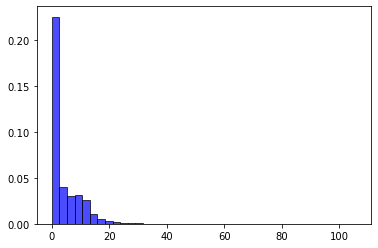

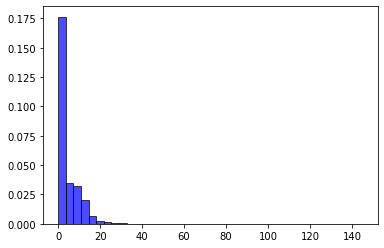

In [48]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    inp, out = sample_batch
    inp = np.array(sample_batch[0].reshape(-1,2).cpu())
    out = np.array(out.reshape(-1,2).cpu())
    """
    plt.hist2d(inp[:,0],inp[:,1], bins=60, cmap='Blues')
    plt.show()
    plt.hist2d(out[:,0],out[:,1], bins=60, cmap='Blues')
    plt.show()
    """
    inn = np.sqrt(np.square(inp[:,0]) + np.square(inp[:,1]))
    ouu = np.sqrt(np.square(out[:,0]) + np.square(out[:,1]))
    print(inp)
    plt.hist(inn[inn != 0], bins=40, facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.show()
    plt.hist(ouu[ouu != 0], bins=40, facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.show()
        
for i_batch, sample_batch in enumerate(train_loader):
    #inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break